In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# add code directory to path
import sys
import os
sys.path.append(os.path.join(os.path.abspath(''), 'code'))

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
from config import load_config

In [5]:
config = load_config("config_hammer.yaml")
sequences_df = pd.read_csv(config["dataset_path"])

Loaded configuration:
  root_path: /home/labs/fleishman/omripo/Projects/adaptive_learning
  data_dir_name: data
  pretraining_dir_name: pretraining
  bootstrap_dir_name: bootstrap
  results_dir_name: results
  enzyme: NNMT
  substrate: 
  dataset_filename: hammer_full.csv
  tag: dataset_perparation
  weights_filename: final_model.pt
  model_type: plm
  finetune: False
  opmode: mean
  train_type: msa_backbone
  nmuts_column: num_muts
  sequence_column_name: full_seq
  activity_column_name: inactive
  first_column_name: Y20
  last_column_name: F253
  plm_name: esm2_t12_35M_UR50D
  ref_seq: MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLFKIFCLDGVKGDLLIDIGSGPTIYQLLSACESFKEIVVTDYSDQNLQELEKWLKKEPEAFDWSPVVTYVCDLEGNRVKGPEKEEKLRQAVKQVLKCDVTQSQPLGAVPLPPADCVLSTLCLDAACPDLPTYCRALRNLGSLLKPGGFLVIMDALKSSYYMIGEQKFSSLPLGREAVEAAVKEAGYTIEWFEVISQSYSSTMANNEGLFSLVARKLSRPLLEHHHHHH
  bootstrap_indices_prefix: indices
  train_indices: all
  train_fraction: 0.8
  test_indices: [6]
  pos_to_use: [20, 24, 34, 37, 1

In [6]:
from bootstrap import get_oh_table

In [7]:
oh_funclib_df, y, design_numbers = get_oh_table(
    config["dataset_path"],
    first_col=config["first_column_name"],
    last_col=config["last_column_name"],
)

In [8]:
from sklearn.neural_network import MLPClassifier, MLPRegressor

In [12]:
mlp_reg_oh = MLPRegressor(
            hidden_layer_sizes=(128),
            activation="relu",
            learning_rate="invscaling",
            solver="lbfgs",
            random_state=42,
            verbose=True,
            max_iter=20000,
    )

In [13]:
mlp_reg_oh.fit(oh_funclib_df.values, y)

,loss,'squared_error'
,hidden_layer_sizes,128
,activation,'relu'
,solver,'lbfgs'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'invscaling'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,20000
,shuffle,True


In [14]:
pred_weights = pd.DataFrame(
        np.eye(len(oh_funclib_df.columns)), columns=oh_funclib_df.columns
    )
predictions = mlp_reg_oh.predict(pred_weights)
results = pd.DataFrame([i.split("_") for i in oh_funclib_df.columns], columns=["position", "AA"])
results["predictions"] = predictions
results_sorted = results.sort_values("predictions", ascending=False, inplace=False)

/home/labs/fleishman/omripo/Projects/adaptive_learning/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


In [15]:
results_sorted

,position,AA,predictions
50,S213,C,1975.465576
58,Y242,F,1798.188944
26,A198,A,1491.823447
54,S213,N,969.811523
34,A198,V,409.213028
...,...,...,...
66,A247,C,-6.982686
41,S201,M,-8.242004
86,F253,F,-10.335139
30,A198,L,-14.736184


In [16]:
from itertools import combinations

In [17]:
results_list = []
for position in results["position"].unique():
    positon_df = results[results["position"] == position]
    # get all possible distinct AA combinations
    AA_combinations = list(combinations(positon_df["AA"], 2))
    
    # iter over combinations
    for AA_combination in AA_combinations:
        # get the two rows
        row1 = positon_df[positon_df["AA"] == AA_combination[0]]
        row2 = positon_df[positon_df["AA"] == AA_combination[1]]
        # get the difference
        diff = row1["predictions"].values[0] - row2["predictions"].values[0]
        results_list.append(
            {
                "position": position,
                "AA1": AA_combination[0],
                "AA2": AA_combination[1],
                "diff": diff,
            }
        )
        results_list.append(
            {
                "position": position,
                "AA1": AA_combination[1],
                "AA2": AA_combination[0],
                "diff": -diff,
            }
        )
results_df = pd.DataFrame(results_list)
results_df.sort_values("diff", ascending=False, inplace=True)

In [18]:
results_df

,position,AA1,AA2,diff
272,S213,C,H,1999.254897
278,S213,C,S,1972.453629
270,S213,C,G,1970.368312
274,S213,C,M,1961.713105
255,S213,C,A,1951.387671
...,...,...,...,...
254,S213,A,C,-1951.387671
275,S213,M,C,-1961.713105
271,S213,G,C,-1970.368312
279,S213,S,C,-1972.453629


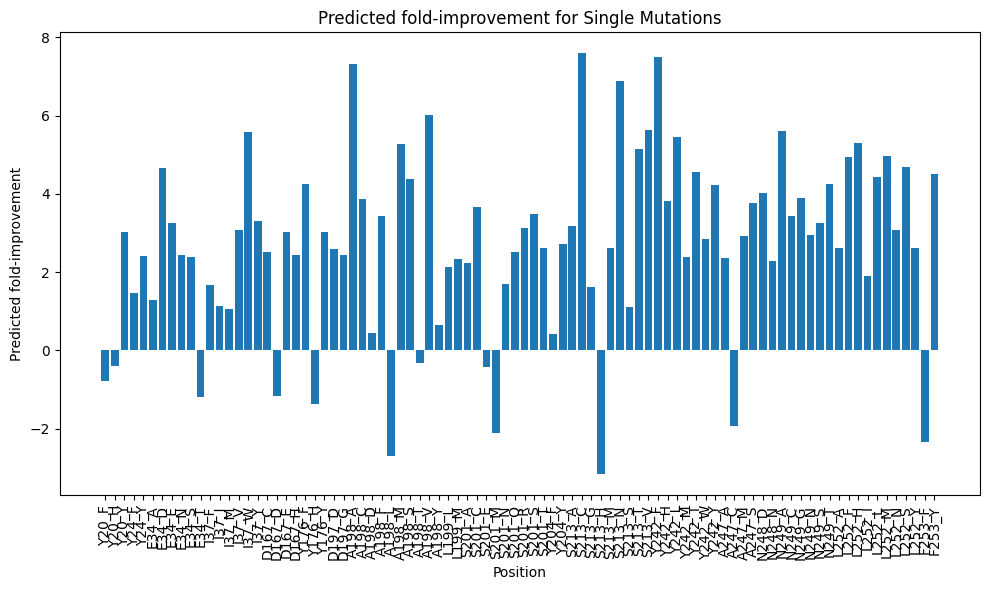

In [47]:
# plot the predictions
plt.figure(figsize=(10, 6))
neg_log = lambda x: np.log(x) if x > 0 else -np.log(-x)
# apply neg_log to predictions
neg_log_predictions = np.array([neg_log(x) for x in predictions])
plt.bar(range(len(predictions)), neg_log_predictions)
plt.xlabel("Position")
plt.ylabel(f"Predicted fold-improvement")
plt.title(f"Predicted fold-improvement for Single Mutations")
plt.xticks(range(len(predictions)), oh_funclib_df.columns, rotation=90)
plt.tight_layout()
plt.show()

[ 4.56249600e-01 -1.48120579e+00  2.04278034e+01  4.34436753e+00
  1.11703845e+01  3.62594350e+00  1.05032937e+02  2.56079352e+01
  1.13701001e+01  1.09280776e+01 -3.32555940e+00  5.29719340e+00
  3.13815609e+00  2.85998564e+00  2.14275942e+01  2.66706628e+02
  2.69817966e+01  1.24908899e+01 -3.22512626e+00  2.07363534e+01
  1.14881040e+01  6.99043379e+01 -3.96410187e+00  2.05104748e+01
  1.33051281e+01  1.13186525e+01  1.49182345e+03  4.77670920e+01
 -6.46485950e-01  3.09950741e+01 -1.47361840e+01  1.93907466e+02
  8.02661230e+01 -1.38107988e+00  4.09213028e+02  1.92667123e+00
  8.49533294e+00  1.03610568e+01  9.29362010e+00  3.94503864e+01
 -1.53022050e+00 -8.24200431e+00  5.40807024e+00  1.24095135e+01
  2.25194315e+01  3.22949782e+01  1.35773913e+01  1.53577210e+00
  1.51807184e+01  2.40779045e+01  1.97546558e+03  5.09726365e+00
 -2.37893211e+01  1.37524709e+01  9.69811523e+02  3.01194690e+00
  1.71290043e+02  2.81701515e+02  1.79818894e+03  4.58060703e+01
  2.31293802e+02  1.09434

array(None, dtype=object)